Implement non-local means (NLM) filtering algorithm for the application of denoising

You are given a noisy image, $\mathbf{g}$ (krishna_0_001. png), corresponding to a latent image, $\mathbf{f}$ (krishna.png), corrupted with additive Gaussian noise of mean 0 and variance $0.001$. Your task is to apply NLM filtering on $\mathbf{g}$ following the steps in the given pseudocode to arrive at the denoised image, $\hat{\mathbf{f}}$.

The parameters of the algorithm are the search neighbourhood radius $W$, the similarity neighbourhood radius $W_{\text {sim }}$ and the filter parameter $\sigma_{N L M}$. A radius of $W$ at a pixel denotes a window size of $(2 W+1) \times(2 W+1)$ around that pixel. The same applies to $W_{\text {sim }}$.

Q1. Show plots between the PSNR between $\mathbf{f}$ and $\hat{\mathbf{f}}$ (y-axis) for different NLM filter parameter values $\sigma_{N L M}=0.1$ to $0.5$ in steps of $0.1$ ( $\mathrm{x}$-axis) for the following search radius and similarity radius settings:


(a) $W=3, W_{\text {sim }}=3$,

(b) $W=5, W_{\text {sim }}=3$

Show two plots in the same window with two different colours corresponding to (a) and (b). Compare the PSNR plots with the baseline PSNR between the noisy image $\mathbf{g}$ and the latent image $\boldsymbol{f}$.

Q2. We will now compare NLM filtering with the traditional Gaussian filtering. Denoise $\mathbf{g}$ using space-invariant Gaussian filter with $\sigma_{g}=0.1$ to $0.5$ in steps of $0.1$ having a kernel window size of $7 \times 7$ for all $\sigma_{g}$ values. Calculate the PSNR between the denoised images and $\mathbf{f}$. Add this plot to the plot window in $\mathbf{Q} 1$.

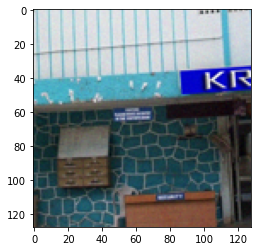

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

noisyimage_g=mpimg.imread('krishna_0_001.png')
plt.imshow(noisyimage_g,'gray')

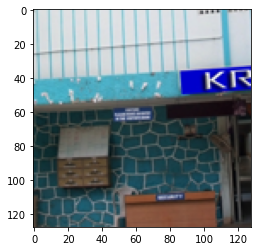

In [2]:
latentimage_f=mpimg.imread('krishna.png')
plt.imshow(latentimage_f,'gray')

In [3]:
"""Zero padding the RGB image so that the resulting image after performing the non-local means (NLM) algorithm should be of the
   same shape as the original image. For a given NLM search neighbourhood radius $W$ and the similarity neighbourhood radius
   $W_{sim}$, padding an image with zeroes of thickness $W+W_{sim}$ on each side."""

def zero_pad_image_RGB(image, w, w_sim):
    x, y, _ = np.shape(image)
    pad_size = w+w_sim
    padded_image = np.zeros((x+2*pad_size, y+2*pad_size, 3))
    for i in range(3):
        padded_image[pad_size:-pad_size,
                     pad_size:-pad_size, i] = image[:, :, i]
    return padded_image

# Intensity Gaussian
Given an image patch $\mathcal{N}_{p}$ around a pixel $p$, the weight $w_{pq}$ another patch $\mathcal{N}_{q}$ around a pixel $q$ gets during NLM filtering depends on the forbenius norm of the difference between $\mathcal{N}_{p}$ and $\mathcal{N}_{q}$.

$$
w_{pq} \propto exp\left[{\frac{\|\mathcal{N}_{p}-\mathcal{N}_{q}\|^{2}_{F}}{2\sigma^{2}}}\right]
$$

$\sigma$ decides the sensitivity. If $\sigma$ is small, $p$ will get a very low contribution from $q$ even if $\mathcal{N}_{q}$ is slightly different from $\mathcal{N}_{p}$. The reverse happens for large $\sigma$. 

In [4]:
def intensity_gaussian(N_p, N_q, sigma):
    if sigma > 0:
        return np.exp(np.sum((-1*(N_p-N_q)**2)/(2*sigma**2)))
    else:
        if np.sum(np.abs(N_p-N_q)) == 0:
            return 1
        else:
            return 0

# Filtered intensity at pixel p
Given an image patch $\mathcal{N}_{p}$ of size $(2W_{sim}+1)\times (2W_{sim}+1)$ around a pixel $p$, calculate the filtered image intensity at $p, g(p)$. 

$$
g(p) = \frac{1}{Z_{p}}\Sigma_{q\in G_{p}}G_{\sigma}(\mathcal{N}_{p}-\mathcal{N}_{q})f(q)
$$

$G_{p}$ is a neighborhood of size $(2W+1)\times (2W+1)$ around $p$, $G_{\sigma}$ is the Gaussian intensity weight for a given $\sigma$ as defined in the previous section, and, $f(q)$ is the image intensity at pixel $q$. $Z_{p}$ is a normalizing constant given by

$$
Z_{p} = \Sigma_{q\in G_{p}}G_{\sigma}(\mathcal{N}_{p}-\mathcal{N}_{q})
$$

This ensures that we do not brighten or darken the image while filtering.

In [5]:
def filtered_intensity(imagepatch, surroundings, d, W_sim, sigma, return_kernel=False):
    # create a weight matrix of the required size
    # here d input is the sum W + W_sim and hence, W_sim is subtracted whenever required 
    weights = np.zeros((2*d+1 - 2*W_sim, 2*d+1 - 2*W_sim))
    filtered_val = 0
    for i in range(W_sim, 2*d+1 - W_sim):
        for j in range(W_sim, 2*d+1 - W_sim):
            # get the patch around another pixel of the size (2*W_sim+1, 2*W_sim+1)
            N_q = surroundings[i-W_sim:i+W_sim+1, j-W_sim:j+W_sim+1]
            # get the weights
            weights[i-W_sim, j-W_sim] = intensity_gaussian(imagepatch, N_q, sigma)
            # increment the filtered value
            filtered_val += weights[i-W_sim, j-W_sim]*surroundings[i, j]
    # if the kernel is required for visualization, return it. Else return
    # only the filtered value. Normalize both the kernel and the weights so
    # that the weights sum up to 1 and we do not brighten or dim the image
    if return_kernel:
        return filtered_val/np.sum(weights), weights/np.sum(weights)
    else:
        return filtered_val/np.sum(weights)

# Non-Local Mean filtering

In [6]:
def NLM(image,w,w_sim,sigma):
    x, y, z = np.shape(image)
    d=w+w_sim
    # zero pad the image
    padded_image = zero_pad_image_RGB(image, w, w_sim)
    filtered_image = np.zeros((x, y, 3))
    # for each channel RGB
    for channel in range(3):
        padded_image_channel = padded_image[:, :, channel]
        for i in range(d, x+d):
            for j in range(d, y+d):
                # get the patch around a pixel of shape (2*w_sim+1, 2*w_sim+1)
                imagepatch = padded_image_channel[i -w_sim:i+w_sim+1, j-w_sim:j+w_sim+1]
                # get its surroundings of shape (2*w+1, 2*w+1)
                surroundings = padded_image_channel[i-d:i+d+1, j-d:j+d+1]
                # get the filtered value
                filtered_image[i-d, j-d, channel] = filtered_intensity(imagepatch, surroundings, d, w_sim, sigma)
    return filtered_image

In [7]:
#plt.imshow(filtered_image)

In [8]:
#plt.imshow(filtered_image-noisyimage_g)

# PSNR 
PSNR between a noisy image and latent image can be calculated as follows : 

$$
PSNR(dB)=20log_{10}\left(\frac{MAX_{f}}{\sqrt{MSE}}\right)
$$

$MAX_{f}$ is the maximum intensity value in the underlying image and $MSE$ is the mean-squared error between the noisy image and the underlying image. If the $MSE$ is zero, return a really high but finite value to prevent division by zero errors.

In [9]:
def PSNR(latentimage_f, filtered_image):
    mse = np.mean((filtered_image-latentimage_f)**2)
    if mse > 0:
        return 20*np.log10(np.max(latentimage_f)/np.sqrt(mse))
    else:
        return np.float128('1e354')

# Gaussian Kernel

In [10]:
import numpy as np
def generate_kernel(sigma):
    k= int(np.ceil(6*sigma+1));  #kernel size
    if k==1:
        return np.ones((k,k)); #to avoid division by 0 when sigma=0.0
    #if kernel size is even then consider the next odd value
    if k%2==0:
        k = k+1;
    #creating empty kernel grid
    kernel = np.zeros((k,k));
    d=k//2 
    for i in range(k):
        for j in range(k):
            kernel[i,j]=np.exp((-(i-d)**2-(j-d)**2)/(2*sigma**2))
    kernel=kernel/np.sum(kernel)
    return kernel

# Convolution

In [11]:
def convolution(image,kernel) :
    k = len(kernel)
    d=k//2 #center of kernel
    if d==0:
        return image
    [x,y] = np.shape(image)
    filtered_image = np.zeros((x,y))
    zero_padded_image = np.zeros((x+2*d, y+2*d))
    zero_padded_image[d:-d, d:-d] = image #fit the image to the center of the zero padded image
    for i in range(d, x+d):
        for j in range(d, y+d):
            patch = zero_padded_image[i-d:i+d+1, j-d:j+d+1] #patch of the input image on which kernel needs to be applied for this iteration
            filtered_image[i-d, j-d] = np.sum(kernel*patch) #apply kernel and sum these values 
    return filtered_image

# Gaussian denoising 

In [12]:
def gaussian_denoising_RGB(image, sigma, w):
    x, y, _ = np.shape(image)
    kernel = generate_kernel(sigma)
    filtered_image = np.zeros((x, y, 3))
    for channel in range(3):
        filtered_image[:, :, channel] = convolution(image[:, :, channel], kernel)
    return filtered_image

***Denoising the noisy image using gaussian and NLM filtering and storing the filtered image and corresponding PSNR values in the Gaussian_data and NLM_data.***

In [13]:
sigma_vals = [0.1, 0.2, 0.3, 0.4, 0.5]
w_sim = 3
w_vals = [3, 5]
gaussian_kernel_size = 7
NLM_data = {}
Gaussian_data = {}
for sigma in sigma_vals:
    gaussian_filtered_image = gaussian_denoising_RGB(noisyimage_g, sigma, gaussian_kernel_size)
    Gaussian_data[sigma] = (gaussian_filtered_image,PSNR(latentimage_f, gaussian_filtered_image))
for sigma in sigma_vals:
    for w in w_vals:
        NLM_filtered_image = NLM(noisyimage_g, w, w_sim, sigma)
        NLM_data[(sigma, w)] = (NLM_filtered_image,PSNR(latentimage_f, NLM_filtered_image))

In [14]:
#plt.imshow(NLM_data[(sigma_vals[4], w_vals[0])][0])

# Plotting

***NLM filtered images for different sigma,w and w_sim values***

(-0.5, 127.5, 127.5, -0.5)

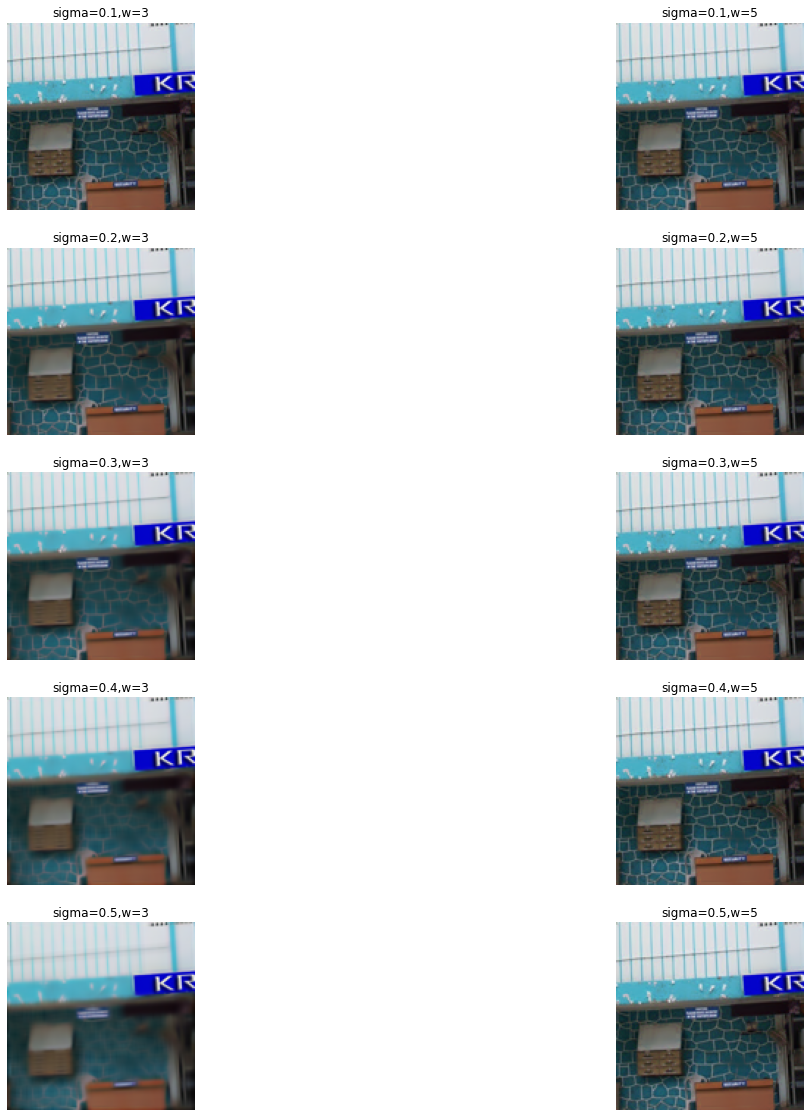

In [15]:
plt.subplots(5,2,figsize=(20,20))

plt.subplot(5,2,1)
plt.imshow(NLM_data[(sigma_vals[0], w_vals[0])][0])
plt.title("sigma=0.1,w=3")
plt.axis('off')

plt.subplot(5,2,3)
plt.imshow(NLM_data[(sigma_vals[1], w_vals[0])][0])
plt.title("sigma=0.2,w=3")
plt.axis('off')

plt.subplot(5,2,5)
plt.imshow(NLM_data[(sigma_vals[2], w_vals[0])][0])
plt.title("sigma=0.3,w=3")
plt.axis('off')

plt.subplot(5,2,7)
plt.imshow(NLM_data[(sigma_vals[3], w_vals[0])][0])
plt.title("sigma=0.4,w=3")
plt.axis('off')

plt.subplot(5,2,9)
plt.imshow(NLM_data[(sigma_vals[4], w_vals[0])][0])
plt.title("sigma=0.5,w=3")
plt.axis('off')

plt.subplot(5,2,2)
plt.imshow(NLM_data[(sigma_vals[0], w_vals[1])][0])
plt.title("sigma=0.1,w=5")
plt.axis('off')

plt.subplot(5,2,4)
plt.imshow(NLM_data[(sigma_vals[0], w_vals[1])][0])
plt.title("sigma=0.2,w=5")
plt.axis('off')

plt.subplot(5,2,6)
plt.imshow(NLM_data[(sigma_vals[0], w_vals[1])][0])
plt.title("sigma=0.3,w=5")
plt.axis('off')

plt.subplot(5,2,8)
plt.imshow(NLM_data[(sigma_vals[0], w_vals[1])][0])
plt.title("sigma=0.4,w=5")
plt.axis('off')

plt.subplot(5,2,10)
plt.imshow(NLM_data[(sigma_vals[0], w_vals[1])][0])
plt.title("sigma=0.5,w=5")
plt.axis('off')

***Gaussian filtered images for different sigma values***

(-0.5, 127.5, 127.5, -0.5)

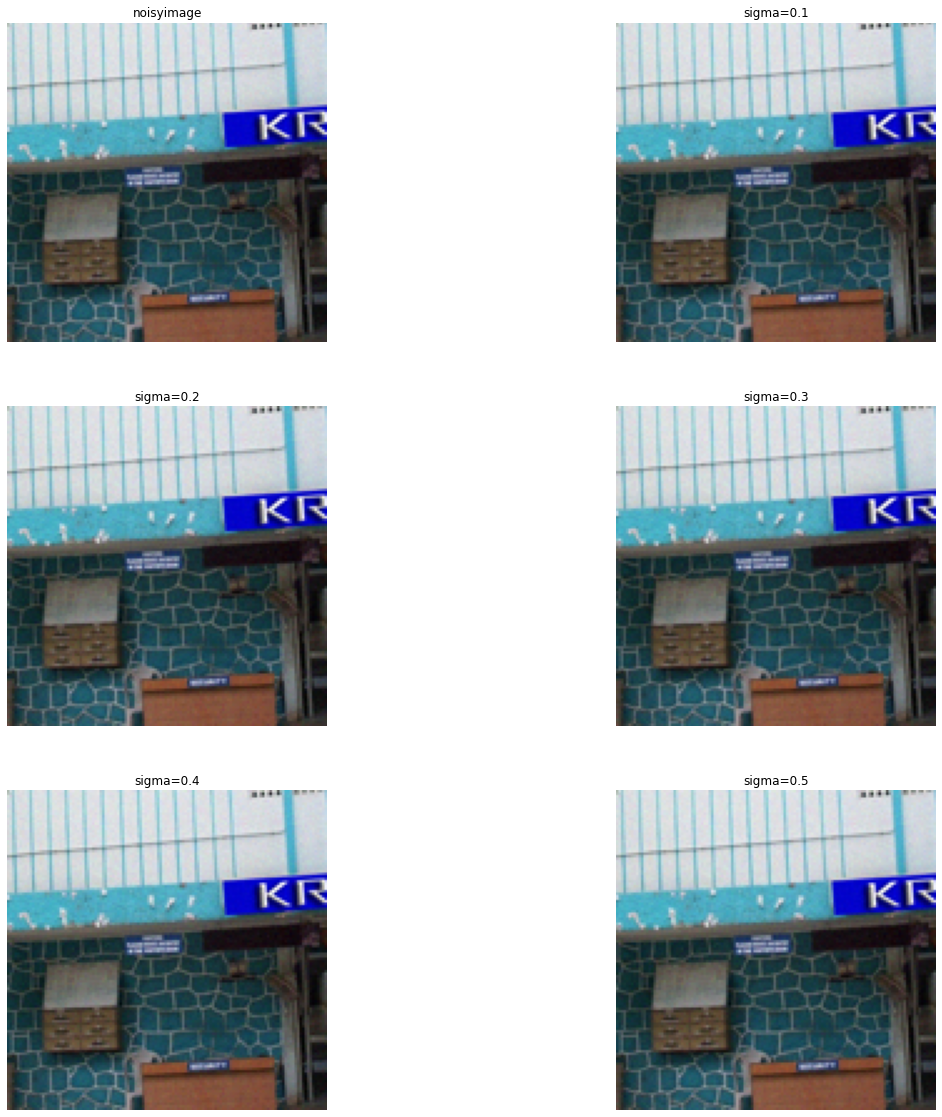

In [17]:
plt.subplots(3,2,figsize=(20,20))

plt.subplot(3,2,1)
plt.imshow(noisyimage_g)
plt.title("noisyimage")
plt.axis('off')

plt.subplot(3,2,2)
plt.imshow(Gaussian_data[sigma_vals[0]][0])
plt.title("sigma=0.1")
plt.axis('off')

plt.subplot(3,2,3)
plt.imshow(Gaussian_data[sigma_vals[0]][0])
plt.title("sigma=0.2")
plt.axis('off')

plt.subplot(3,2,4)
plt.imshow(Gaussian_data[sigma_vals[0]][0])
plt.title("sigma=0.3")
plt.axis('off')

plt.subplot(3,2,5)
plt.imshow(Gaussian_data[sigma_vals[0]][0])
plt.title("sigma=0.4")
plt.axis('off')

plt.subplot(3,2,6)
plt.imshow(Gaussian_data[sigma_vals[0]][0])
plt.title("sigma=0.5")
plt.axis('off')

# PSNR plots 

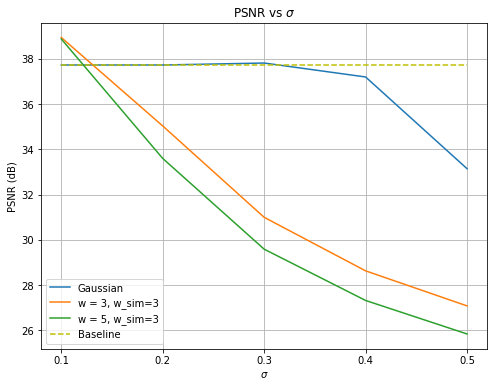

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(sigma_vals, [Gaussian_data[sigma][1] for sigma in sigma_vals])
plt.plot(sigma_vals, [NLM_data[(sigma, w_vals[0])][1] for sigma in sigma_vals])
plt.plot(sigma_vals, [NLM_data[(sigma, w_vals[1])][1] for sigma in sigma_vals])
plt.plot(sigma_vals, [PSNR(latentimage_f, noisyimage_g)for sigma in sigma_vals], 'y--')
plt.xlabel(r"${\sigma}$")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.legend(["Gaussian", "w = 3, w_sim=3", "w = 5, w_sim=3", "Baseline"])
plt.xticks(sigma_vals)
plt.title(r"PSNR vs $\sigma$")
plt.show()

***Observations:***
1. Gaussian denoising is performing well for lower values of sigma and performance reduces as sigma value increases.
2. NLM filtering for sigma = 0.1 provides significant noise reduction as we can see the PSNR is higher even than the baseline.
3. NLM filtering is performing worse than the gaussian filtering when sigma values and Window sizes are increased.



***For the following filtering settings: (a) $W=5, W_{\text {sim }}=3, \sigma_{N L M}=0.5$ for the NLM filtering, and (b) $\sigma_{g}=1.0$ for Gaussian filtering, and at the following pixel locations $\mathbf{p}$ : (i) row $=31$, column $=$ 46 , and (ii) row $=38$, column $=58$, (total four combinations), do Q3 and Q4.***

Q3. Show the 1111 filter (kernel) as an image.

Q4. Show the 1111 image patch from the noisy image and the denoised images.


In [20]:
def visualize(image, row1, column1, row2, column2, W=None, W_sim=None, sigma=None, is_kernel=False):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7), constrained_layout=True)

    if not is_kernel:
        if W is not None:
            ax1.imshow(image[row1-W-1:row1+W, column1-W-1:column1+W])
            ax2.imshow(image[row1-W-1:row1+W, column2-W-1:column2+W])
            ax3.imshow(image[row2-W-1:row2+W, column1-W-1:column1+W])
            ax4.imshow(image[row2-W-1:row2+W, column2-W-1:column2+W])
            ax1.title.set_text(f"row : {row1}, column : {column1}")
            ax2.title.set_text(f"row : {row1}, column : {column2}")
            ax3.title.set_text(f"row : {row2}, column : {column1}")
            ax4.title.set_text(f"row : {row2}, column : {column2}")
            plt.show()
        else:
            print("Invalid Inputs")
    else:
        if (W is not None) and (W_sim is not None) and (sigma is not None):
            padded_image = zero_pad_image_RGB(image, W, W_sim)
            d = W+W_sim
            k1 = np.zeros((2*W+1, 2*W+1, 3))
            k2 = np.zeros((2*W+1, 2*W+1, 3))
            k3 = np.zeros((2*W+1, 2*W+1, 3))
            k4 = np.zeros((2*W+1, 2*W+1, 3))
            for channel in range(3):
                _, k1[:, :, channel] = filtered_intensity(image[row1-1-W_sim:row1+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)
                
                _, k2[:, :, channel] = filtered_intensity(image[row1-1-W_sim:row1+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row1-1:row1+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
                
                _, k3[:, :, channel] = filtered_intensity(image[row2-1-W_sim:row2+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)

                _, k4[:, :, channel] = filtered_intensity(image[row2-1-W_sim:row2+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                                 padded_image[row2-1:row2+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
               
            # Normalizing the kernels before displaying for better visualization
            ax1.imshow(k1*1/np.max(k1))
            ax2.imshow(k2*1/np.max(k2))
            ax3.imshow(k3*1/np.max(k3))
            ax4.imshow(k4*1/np.max(k4))
            ax1.title.set_text(f"row : {row1}, column : {column1}")
            ax2.title.set_text(f"row : {row1}, column : {column2}")
            ax3.title.set_text(f"row : {row2}, column : {column1}")
            ax4.title.set_text(f"row : {row2}, column : {column2}")
            ax1.axis('off')
            ax2.axis('off')
            ax3.axis('off')
            ax4.axis('off')
            plt.show()
        else:
            print("Invalid Inputs")

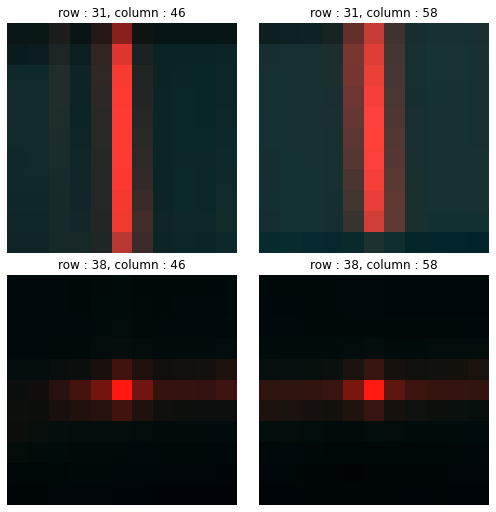

In [22]:
rows = (31, 38)
columns = (46, 58)
#NLM kernels for all four row-column combination
visualize(latentimage_f, rows[0], columns[0], rows[1],columns[1], W=5, W_sim=3, sigma=0.5, is_kernel=True)

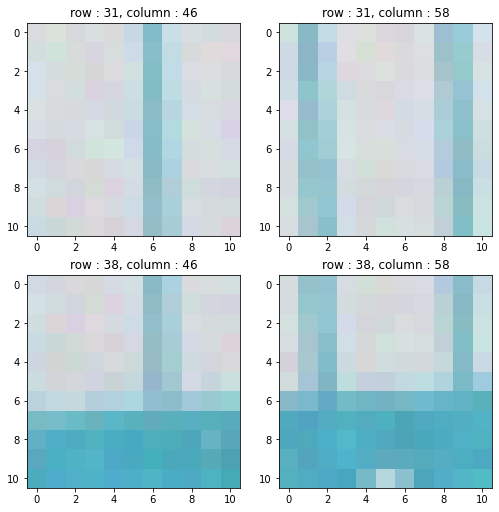

In [23]:
#image patches for all four row-column combinations for W=5
visualize(noisyimage_g, rows[0], columns[0],rows[1], columns[1], W=5, is_kernel=False)

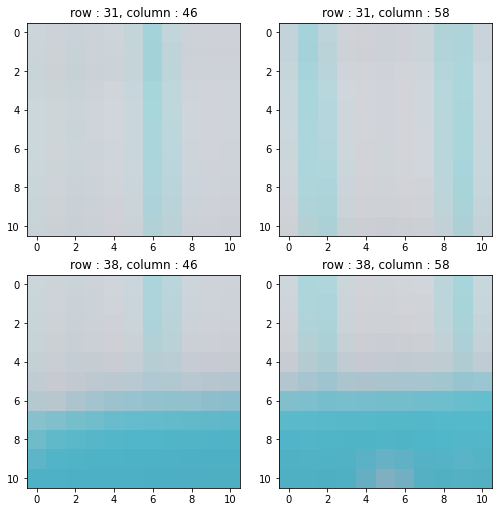

In [24]:
#NLM Filtered image patch for W=5 implies 11x11 filter , sigma=0.5
visualize(NLM_data[(0.5, 5)][0], rows[0], columns[0],rows[1], columns[1], W=5, is_kernel=False)

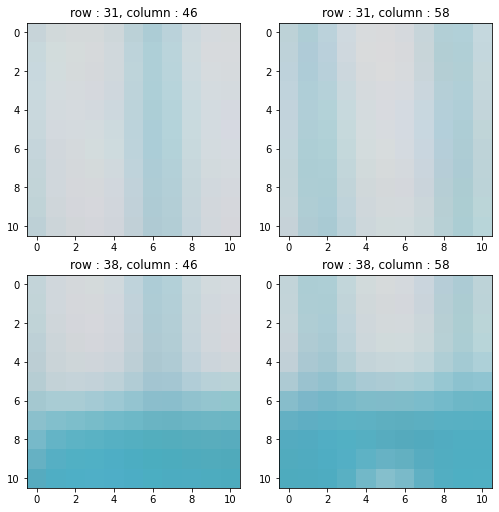

In [25]:
#gaussian filtered image patch for W=5,sigma=1.0
visualize(gaussian_denoising_RGB(noisyimage_g, sigma=1, w=5),rows[0], columns[0], rows[1], columns[1], W=5, is_kernel=False)

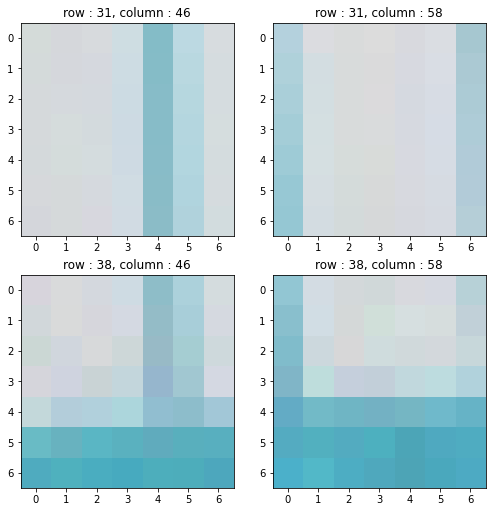

In [26]:
#NLM filtered image patch for W=5 and sigma=0.1
visualize(NLM_data[(0.1, 5)][0], rows[0], columns[0],rows[1], columns[1], W=3, is_kernel=False)

***Observation:***
NLM kernels add a lot of weight only to pixels whose neighborhood is similar to the neighborhood of the pixel under consideration.